In [1]:
import csv
import numpy as np
import cv2
import matplotlib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D,Activation
from keras.layers import Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import optimizers
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [9]:
## Utility functions
## load image paths and angles for given set
def load_data( data_dir ) :
    image_paths,angles = [],[]
    log_file = '/driving_log.csv'
    log_file_path = data_dir+log_file
    with open(log_file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            ## center image
            image_paths.append(get_image_path(line[0],data_dir ))
            angles.append(get_streeing_angle(float(line[3]),camera_position='centre' ))
            ## left image
            image_paths.append(get_image_path(line[1],data_dir ))
            angles.append(get_streeing_angle(float(line[3]),camera_position='left' ))
            ## right image
            image_paths.append(get_image_path(line[2],data_dir ))
            angles.append(get_streeing_angle(float(line[3]),camera_position='right' ))
    return image_paths, angles

## get relative image path 
def get_image_path( absolute_path, relative_path):
    file_name = absolute_path.split('/')[-1]
    return relative_path+'/IMG/'+file_name

## load image from given path 
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image
## get steering angle for an image. For left and right camera images, 
## center image steering angles is modified
def get_streeing_angle( angle, camera_position='centre' ):
    radian = 360/ ( 2 * np.pi * 25.0)
    ## car width assumption -  1.2 meters. Also tan(x) when x is small is x
    width = 1.2
    distance = 25
    change = width/distance * radian 
    if ( camera_position is 'centre' ):
        return float(angle)
    elif (camera_position is 'left'):
        return float(angle + change )
    elif ( camera_position is 'right'):
        return float(angle -change)

In [14]:
lines = []

log_file = '/driving_log.csv'
# 'udacity_data','generated_data'
data_dirs = [ 'udacity_data','generated_data','xbox_training/track1_central','xbox_training/track1_reverse',
             'xbox_training/track1_recovery','xbox_training/track1_recovery_reverse'  ]
image_paths = []
angles = []
for d in data_dirs:
    d = './training_data/'+d
    paths,angs = load_data(d)
    image_paths.extend(paths)
    angles.extend(angs)
print("Loaded all image paths and angles.")

Loaded all image paths and angles.


In [15]:
X_samples = np.array(image_paths)
y_samples =  np.array(angles)
print (X_samples.shape, y_samples.shape)


(65916,) (65916,)


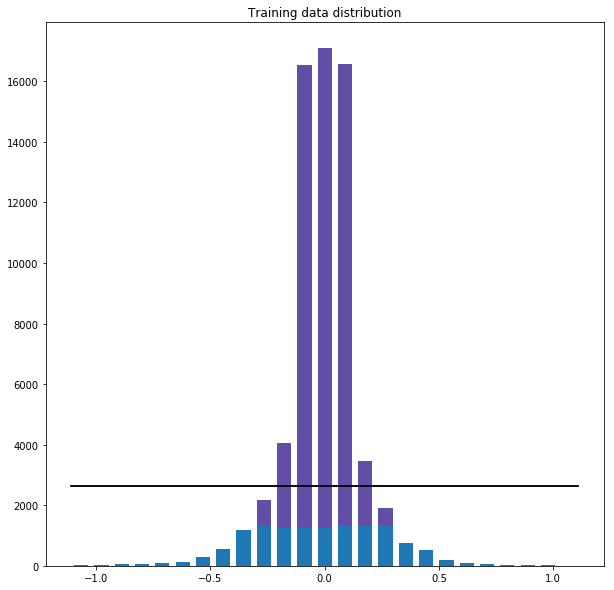

In [16]:


## Plot histogram of the angle changes
def plot_histogram( data ):
    plt.figure()
    plt.hist(data, bins=25, facecolor='green', alpha=0.5)
    plt.xlabel('Angles')
    plt.ylabel('Frequency')
    plt.title("Frequency distribution over angles")
    plt.grid(True)
    plt.show()


## plot histogram of steering changes
plt.figure(figsize=(10,10))
plt.title("Training data distribution")
num_bins = 25
avg_samples_per_bin = len(y_samples)/num_bins
hist, bins = np.histogram(y_samples, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, color='#624ea7')
plt.plot((np.min(y_samples), np.max(y_samples)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
#plot_histogram(y_samples)

keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []


for i in range(len(y_samples)):
    for j in range(num_bins):
        if bins[j] < y_samples[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)

X_samples = np.delete(X_samples, remove_list, axis=0)
y_samples = np.delete(y_samples, remove_list)

hist, bins = np.histogram(y_samples, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(y_samples), np.max(y_samples)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

In [17]:
## Training and Validation data
## also does shuffle of the data
#X_train,X_valid,y_train,y_valid = train_test_split(X_samples,y_samples,test_size=0.3)
X_train_paths = X_samples
y_train = y_samples
print('Train:', X_train_paths.shape, y_train.shape)

## load validation data
v_paths,v_angles = load_data('./training_data/xbox_training/track1_test/')
X_valid_paths = np.array(v_paths)
y_valid = np.array(v_angles)
print('Test:', X_valid_paths.shape, y_valid.shape)

Train: (13269,) (13269,)
Test: (2880,) (2880,)


In [18]:
## load images
train_images = []
test_images = []

for i in X_train_paths:
    train_images.append(get_image(i))
for i in X_valid_paths:
    test_images.append(get_image(i))
    
X_train = np.array(train_images)
X_valid = np.array(test_images)

print ("Done loading images.")
print (X_train.shape, X_valid.shape)


Done loading images.
(13269, 160, 320, 3) (2880, 160, 320, 3)


In [54]:
## Preprocessing and Augmenting Functions
# Flip image
def random_flip(image, angle):
    rand=np.random.randint(0,2)
    if rand==1:
        image=cv2.flip(image,1)
        angle = -angle
    return image,angle


## add shear
## Shear  is used to shift one part of an image to a direction and the other part
## to the opposite direction. This will give us more turning examples
def random_shear( image, angle, shear_range ):
    height,width,ch = image.shape
    r_x= np.random.randint(-shear_range, shear_range+1)
    #print (r_x)
    radian = 360/ ( 2 * np.pi *25.0 )
    ## pick a point. CV2 takes width, height
    point = [width/2+r_x, height/2]
    pt1 = np.float32([[0,height],[width,height],[width/2, height/2]])
    pt2 = np.float32([[0,height],[width,height], point])
    M = cv2.getAffineTransform(pt1, pt2)
    ## new image
    img = cv2.warpAffine(image,M,(width,height),borderMode=1)
    ## angle
    change = r_x/(height/2) * radian /6
    angle +=change
    return img,angle

## add random brightness
def random_bright(image):
    ## convert to HSV
    #img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    r = .25+np.random.uniform()
    image[:,:,2] = image[:,:,2]* r
    #new_image = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return image

## change color to HSV as recommended by NVDIA paper
def change_RGB2HSV(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

## crop image
def crop_image(image):
    horizon = 50
    car = 120
    #print(image.shape)
    new_img = image[horizon:car,:,:]
    ## resize this image
    cropped = cv2.resize(new_img,(160,80),cv2.INTER_AREA)
    
    return cropped

## picks a random image from data set and applies aumentation in terms of random shear, 
## random flip. random brighness and then crops the image
def generate_augmented_data(X, y, mode):
    r = np.random.randint(len(y))
    image, angle = X[r],y[r]
    
    #plt.figure(figsize=(20,20))
    #print('Steering Angle - ',angle)
    #plt.imshow(image)
    image = change_RGB2HSV(image)
    ## random shear
    if ( mode is 'train'):
        #image,angle = shift_image(image,angle,80)
        image,angle = random_shear(image, angle, shear_range=100 )
        image,angle = random_flip(image, angle)
        image = random_bright(image )
        
    image = crop_image(image)
    #print('Steering Angle - ',angle)
    #plt.figure(figsize=(20,20))
    #plt.imshow(image)
    return image, angle
  

## Generated training batch during training process 
def batch_generator(X, y, batch_size=120, mode='train'):
    batch_images = np.zeros((batch_size,80,160,3))
    batch_angles = np.zeros(batch_size)
    while 1:
        X, y = shuffle(X, y)
        for i in range(batch_size):
            image, angle = generate_augmented_data(X, y, mode)
            batch_images[i] = image
            #if (abs(angle) < 0.05 and np.random.normal() < 0.5):
            #    angle = 0
            batch_angles[i] = angle
            
        yield batch_images, batch_angles



In [55]:
batch_size =120
train_generator = batch_generator(X_train, y_train, batch_size=batch_size, mode='train')
valid_generator = batch_generator(X_valid, y_valid,batch_size=batch_size, mode='valid')
  

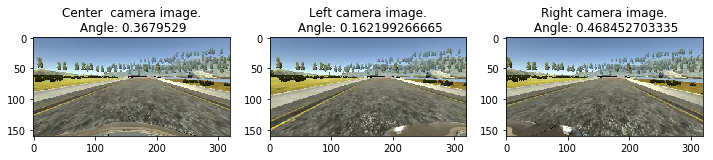

In [52]:
## visualize test data
c_image = X_train[112]
l_image = X_train[11]
r_image = X_train[12]
plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.imshow(X_train[12])
plt.title("Center  camera image.\n Angle: "+str( y_train[12]) )
plt.subplot(1,3,2)
plt.imshow(X_train[11])
plt.title("Left camera image.\n Angle: "+str(y_train[11]))
plt.subplot(1,3,3)
plt.imshow(X_train[16])
plt.title("Right camera image.\n Angle: "+str(y_train[16]))



<Container object of 25 artists>

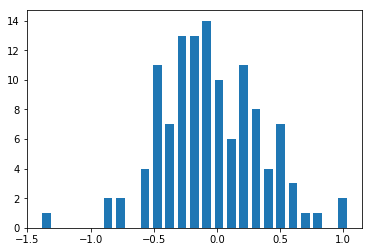

In [64]:

## batch visualization
tb_images = np.zeros((batch_size,80,160,3))
tb_angles = np.zeros(batch_size)
X, y = shuffle(X_train, y_train)
for i in range(120):
    image, angle = generate_augmented_data(X, y, mode='train')
    tb_images[i] = image
    tb_angles[i] = angle

## plot histogram
hist, bins = np.histogram(tb_angles, 25)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)





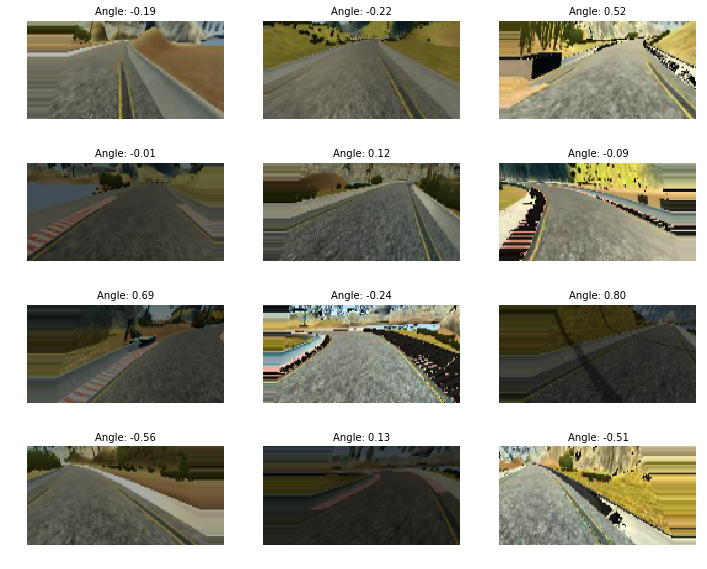

In [63]:
plt.figure(figsize=(12,10))
## image visualization
for i in range(12):
    plt.subplot(4,3,i+1)
    t = tb_images[i].astype(np.uint8)
    plt.imshow(cv2.cvtColor(t, cv2.COLOR_HSV2RGB))
    plt.title('Angle: ' +"{0:.2f}".format(tb_angles[i]),fontsize=10)    
    plt.axis('off')



### Model Details

In [65]:
## Model Details
image_shape=(80,160,3)
model = Sequential()
model.add(Lambda(lambda x : x/255 - 0.5, input_shape=image_shape ))
#model.add(Cropping2D(cropping=((50,20),(0,0)) ))
model.add(Convolution2D(3,1,1, activation='elu'))
model.add(Convolution2D(32,3,3, activation='elu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.3))
model.add(Convolution2D(64,3,3,activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Convolution2D(128,3,3,activation='elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 160, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 80, 160, 3)    12          lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 78, 158, 32)   896         convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 19, 39, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [ ]:
## Compile model
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse',optimizer=adam, metrics=['mae'])
#mhist = model.fit(X_samples,y_samples,validation_split=0.3,
#                       shuffle=True, nb_epoch=5, batch_size=120)
## save model after every epoch
model_checkpoint = ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                                    save_weights_only=False, mode='auto', period=1)
## early stopping
early_stop = EarlyStopping(monitor='loss', min_delta=0.001,
                           patience=1, mode='auto')

mhist = model.fit_generator(train_generator, samples_per_epoch=20000,
                            validation_data=valid_generator,nb_val_samples=3000,
                            nb_epoch=100, verbose=1, callbacks=[model_checkpoint, early_stop ])
#model.save('model.h5')

print("Training Complete.")

Epoch 1/100
19920/20000 [============================>.] - ETA: 2s - loss: 0.1364 - mean_absolute_error: 0.2809   

/Users/13311/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


20040/20000 [==============================] - 790s - loss: 0.1361 - mean_absolute_error: 0.2805 - val_loss: 0.0103 - val_mean_absolute_error: 0.0804
Epoch 2/100
20040/20000 [==============================] - 824s - loss: 0.0819 - mean_absolute_error: 0.2175 - val_loss: 0.0093 - val_mean_absolute_error: 0.0767

In [ ]:
## Plot loss 
plt.plot(mhist.history['loss'])
plt.plot(mhist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Plot model training and validation accuracy
print (mhist.history.keys())
plt.plot(mhist.history['mean_absolute_error'])
plt.plot(mhist.history['val_mean_absolute_error'])
plt.title('mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

